In [ ]:
# Hyperparameters tuning for all ML models

Decision Tree - Best max_depth: 13


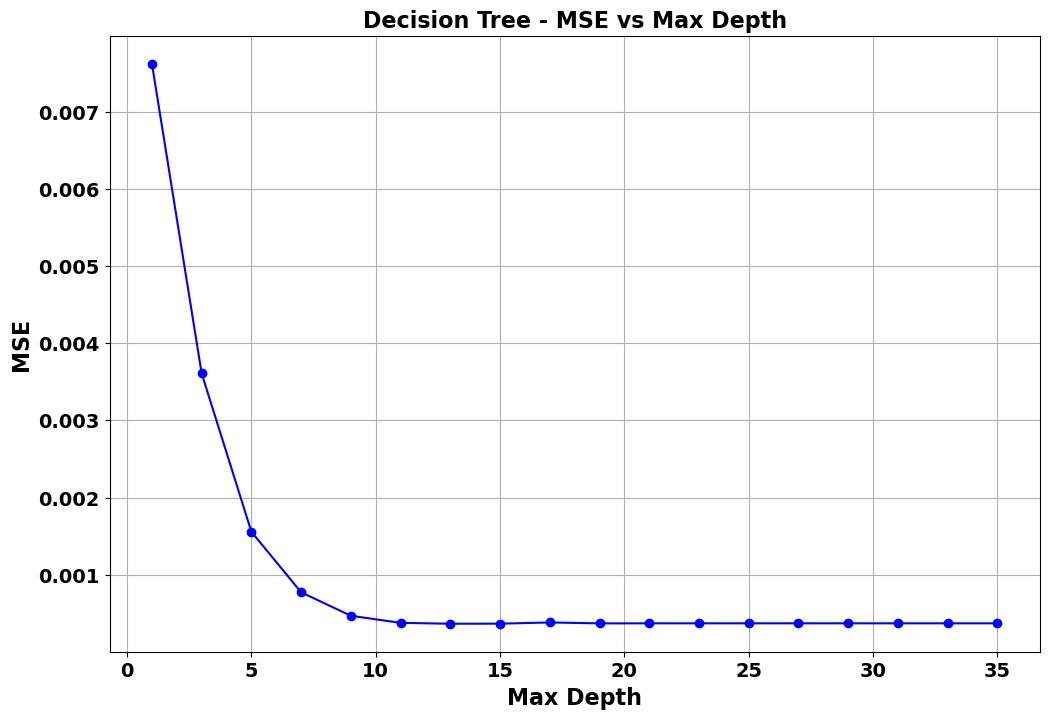

Random Forest - Best hyperparameters: {'max_depth': 20, 'n_estimators': 100}


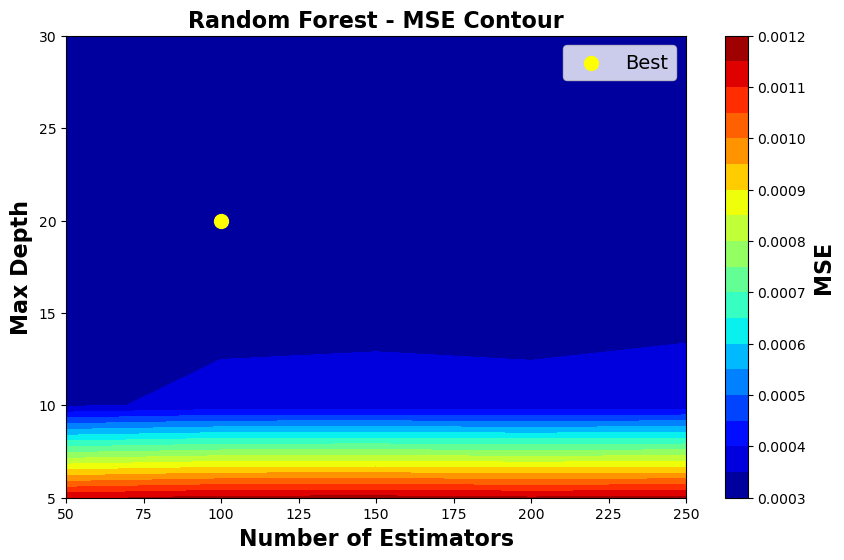

XGBoost - Best Parameters: max_depth=5, n_estimators=350, MAE=0.008588


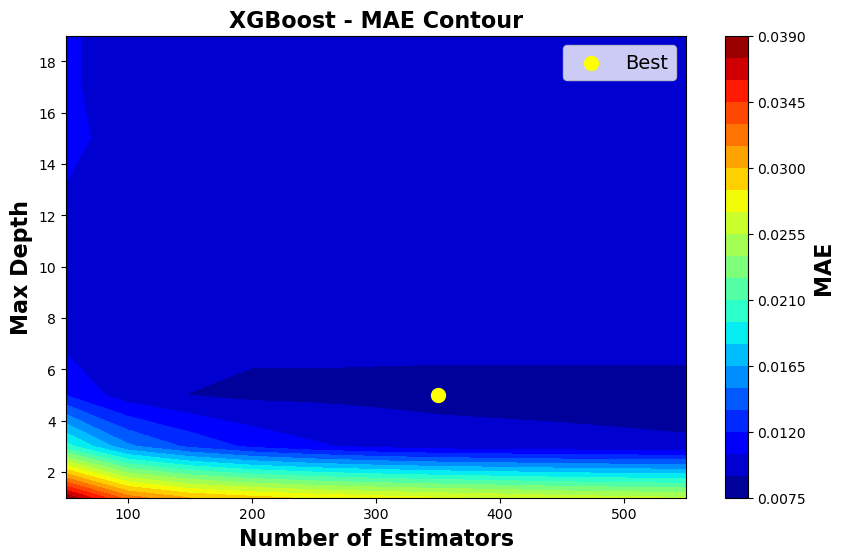

Gradient Boosting - Best Parameters: max_depth=5, n_estimators=450, MAE=0.008524


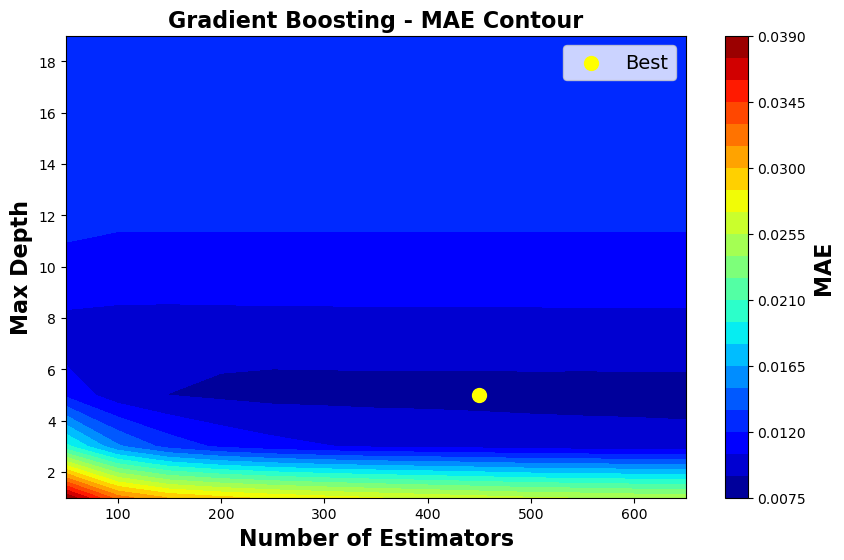

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# -----------------------------
# Load dataset
# -----------------------------
data = pd.read_excel('Supporting_data.xlsx', sheet_name='alpha')
X = data[['Fr', 'Bo', 'Ga', 'Density Ratio']]
z = data[['alpha_g']]

# -----------------------------
# Train-test split
# -----------------------------
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=0)

# -----------------------------
# Scaling
# -----------------------------
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_z = MinMaxScaler()
z_train_scaled = scaler_z.fit_transform(z_train)
z_test_scaled = scaler_z.transform(z_test)

# =============================
# 1. Decision Tree Hyperparameter Tuning
# =============================
max_depth_values_dt = list(range(1, 37, 2))
mse_values_dt = []

for depth in max_depth_values_dt:
    dt = DecisionTreeRegressor(max_depth=depth, random_state=0)
    dt.fit(X_train_scaled, z_train_scaled.ravel())
    z_test_pred_scaled = dt.predict(X_test_scaled)
    z_test_pred = scaler_z.inverse_transform(z_test_pred_scaled.reshape(-1,1))
    mse = mean_squared_error(z_test, z_test_pred)
    mse_values_dt.append(mse)

best_depth_dt = max_depth_values_dt[np.argmin(mse_values_dt)]
print(f"Decision Tree - Best max_depth: {best_depth_dt}")

plt.figure(figsize=(12,8))
plt.plot(max_depth_values_dt, mse_values_dt, marker='o', color='b')
plt.xlabel('Max Depth', fontsize=16, fontweight="bold")
plt.ylabel('MSE', fontsize=16, fontweight="bold")
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.grid(True)
plt.title('Decision Tree - MSE vs Max Depth', fontsize=16, fontweight='bold')
plt.show()

# =============================
# 2. Random Forest Hyperparameter Tuning
# =============================
param_grid_rf = {'max_depth':[5,10,15,20,25,30], 'n_estimators':[50,100,150,200,250]}
grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=0), param_grid_rf, cv=3, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train_scaled, z_train_scaled.ravel())
best_params_rf = grid_search_rf.best_params_
print(f"Random Forest - Best hyperparameters: {best_params_rf}")

# Contour plot
mse_results_rf = np.zeros((len(param_grid_rf['max_depth']), len(param_grid_rf['n_estimators'])))
for i, depth in enumerate(param_grid_rf['max_depth']):
    for j, n_est in enumerate(param_grid_rf['n_estimators']):
        rf = RandomForestRegressor(n_estimators=n_est, max_depth=depth, random_state=0)
        rf.fit(X_train_scaled, z_train_scaled.ravel())
        z_test_pred = scaler_z.inverse_transform(rf.predict(X_test_scaled).reshape(-1,1))
        mse_results_rf[i,j] = mean_squared_error(z_test, z_test_pred)

X_grid, Y_grid = np.meshgrid(param_grid_rf['n_estimators'], param_grid_rf['max_depth'])
plt.figure(figsize=(10,6))
contour = plt.contourf(X_grid, Y_grid, mse_results_rf, levels=20, cmap='jet')
cbar = plt.colorbar(contour)
cbar.set_label('MSE', fontsize=16, fontweight='bold')
plt.xlabel('Number of Estimators', fontsize=16, fontweight='bold')
plt.ylabel('Max Depth', fontsize=16, fontweight='bold')
plt.scatter(best_params_rf['n_estimators'], best_params_rf['max_depth'], color='yellow', s=100, label='Best')
plt.legend(fontsize=14)
plt.title('Random Forest - MSE Contour', fontsize=16, fontweight='bold')
plt.show()

# =============================
# 3. XGBoost Hyperparameter Tuning
# =============================
max_depth_values_xgb = np.arange(1, 21, 2)
n_estimators_values_xgb = np.arange(50, 600, 50)
mae_results_xgb = {}

for depth in max_depth_values_xgb:
    for n_est in n_estimators_values_xgb:
        xgb = XGBRegressor(n_estimators=n_est, max_depth=depth, learning_rate=0.1, random_state=0)
        xgb.fit(X_train_scaled, z_train_scaled.ravel())
        z_test_pred = scaler_z.inverse_transform(xgb.predict(X_test_scaled).reshape(-1,1))
        mae_results_xgb[(depth, n_est)] = mean_absolute_error(z_test, z_test_pred)

best_params_xgb = min(mae_results_xgb, key=mae_results_xgb.get)
best_mae_xgb = mae_results_xgb[best_params_xgb]
print(f"XGBoost - Best Parameters: max_depth={best_params_xgb[0]}, n_estimators={best_params_xgb[1]}, MAE={best_mae_xgb:.6f}")

depths = sorted(set([key[0] for key in mae_results_xgb.keys()]))
estimators = sorted(set([key[1] for key in mae_results_xgb.keys()]))
X_grid, Y_grid = np.meshgrid(estimators, depths)
mae_values = np.array([[mae_results_xgb.get((d,e), np.nan) for e in estimators] for d in depths])

plt.figure(figsize=(10,6))
contour = plt.contourf(X_grid, Y_grid, mae_values, levels=20, cmap='jet')
cbar = plt.colorbar(contour)
cbar.set_label('MAE', fontsize=16, fontweight='bold')
plt.xlabel('Number of Estimators', fontsize=16, fontweight='bold')
plt.ylabel('Max Depth', fontsize=16, fontweight='bold')
plt.scatter(best_params_xgb[1], best_params_xgb[0], color='yellow', s=100, label='Best')
plt.legend(fontsize=14)
plt.title('XGBoost - MAE Contour', fontsize=16, fontweight='bold')
plt.show()

# =============================
# 4. Gradient Boosting Hyperparameter Tuning
# =============================
max_depth_values_gb = np.arange(1, 21, 2)
n_estimators_values_gb = np.arange(50, 700, 50)
mae_results_gb = {}

for depth in max_depth_values_gb:
    for n_est in n_estimators_values_gb:
        gb = GradientBoostingRegressor(n_estimators=n_est, max_depth=depth, learning_rate=0.1, random_state=0)
        gb.fit(X_train_scaled, z_train_scaled.ravel())
        z_test_pred = scaler_z.inverse_transform(gb.predict(X_test_scaled).reshape(-1,1))
        mae_results_gb[(depth, n_est)] = mean_absolute_error(z_test, z_test_pred)

best_params_gb = min(mae_results_gb, key=mae_results_gb.get)
best_mae_gb = mae_results_gb[best_params_gb]
print(f"Gradient Boosting - Best Parameters: max_depth={best_params_gb[0]}, n_estimators={best_params_gb[1]}, MAE={best_mae_gb:.6f}")

depths = sorted(set([key[0] for key in mae_results_gb.keys()]))
estimators = sorted(set([key[1] for key in mae_results_gb.keys()]))
X_grid, Y_grid = np.meshgrid(estimators, depths)
mae_values = np.array([[mae_results_gb.get((d,e), np.nan) for e in estimators] for d in depths])

plt.figure(figsize=(10,6))
contour = plt.contourf(X_grid, Y_grid, mae_values, levels=20, cmap='jet')
cbar = plt.colorbar(contour)
cbar.set_label('MAE', fontsize=16, fontweight='bold')
plt.xlabel('Number of Estimators', fontsize=16, fontweight='bold')
plt.ylabel('Max Depth', fontsize=16, fontweight='bold')
plt.scatter(best_params_gb[1], best_params_gb[0], color='yellow', s=100, label='Best')
plt.legend(fontsize=14)
plt.title('Gradient Boosting - MAE Contour', fontsize=16, fontweight='bold')
plt.show()
